In [1]:
#Data wrangling
import pandas as pd
import numpy as np
#Dataviz
import seaborn as sns 
import matplotlib.pyplot as plt 
#Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
#misc
import itertools
import functools
import os
#
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [40]:
dir_path = 'E:\\Data\\time_series_hw4'
file_names = os.listdir(dir_path)
file_names.remove('I-57-2013-July-1.xls')
file_names

['I-57-2013-June-16.xls',
 'I-57-2013-June-17.xls',
 'I-57-2013-June-18.xls',
 'I-57-2013-June-19.xls',
 'I-57-2013-June-20.xls',
 'I-57-2013-June-21.xls',
 'I-57-2013-June-22.xls',
 'I-57-2013-June-23.xls',
 'I-57-2013-June-24.xls',
 'I-57-2013-June-25.xls',
 'I-57-2013-June-26.xls',
 'I-57-2013-June-27.xls',
 'I-57-2013-June-28.xls',
 'I-57-2013-June-29.xls',
 'I-57-2013-June-30.xls']

In [107]:
def ts_parse(df,date,Direction,sep = '_',prefix='2013-06'):
    """_summary_
    Parse the loaded df to be well formatted 
    Args:
        df (pd.DataFrame): Illinois Dept of Transporation data

    Returns:
        _type_: (pd.DataFrame,pd.DataFrame)
    """
    #0. Get
    col_names = df.iloc[0] + sep +  df.iloc[1]
    #1.Get TS Data:
    df = df.rename({i:j for i,j in zip(df.columns,col_names)},axis=1)
    #0.Get rid of noise 
    to_drop = ['BREAK*ALL'+sep+'******',f'----*----{sep}------']
    df = df.drop(columns=to_drop,axis=1)
    ########
    df_TS = df[3:26] 
    df_TS['Time_ '] = df_TS['Time_ '].apply(lambda x:f"{prefix}-{date}"+' '+x)
    df_TS = df_TS.rename({'Time_ ':'Time'},axis=1)
    df_TS = df_TS.set_index('Time')
    out = pd.melt(df_TS.reset_index(),
        id_vars='Time',
        var_name='Location_id', 
        value_vars=list(df_TS.columns), # list of days of the week
        value_name='Count')
    out.insert(0,'Direction',Direction)
    return out

In [108]:
def Read_IDOT(file_path,name,RETURN_E = False,prefix='2013-06'):
    date = name.split('.')[0][-2:]
    df_s0 = pd.read_excel(file_path,sheet_name='Sheet0',skiprows=range(0,1),usecols="C:ZZ")
    df_s1 = pd.read_excel(file_path,sheet_name='Sheet1',skiprows=range(0,1),usecols="C:ZZ")
    df_TS_1 = ts_parse(df_s0,date,'N',prefix=prefix)
    df_TS_2 = ts_parse(df_s1,date,'S',prefix=prefix)
    df_TS = pd.concat([df_TS_1,df_TS_2])
    return df_TS

In [109]:
df_TS= pd.DataFrame()
################################
for name in file_names:
    file_path = dir_path + '\\' + name 
    df_TS_temp = Read_IDOT(file_path,name)
    df_TS = pd.concat([df_TS,df_TS_temp])

In [57]:
#df_TS.to_csv('I-57-clean.csv')
df_TS = pd.read_csv('I-57-clean.csv',index_col=0)

### EDA

In [58]:
df_TS.head()

,Direction,Time,Location_id,Count
0,N,2013-06-16 01:00,SI80_3LCS,1024
1,N,2013-06-16 02:00,SI80_3LCS,555
2,N,2013-06-16 03:00,SI80_3LCS,340
3,N,2013-06-16 04:00,SI80_3LCS,255
4,N,2013-06-16 05:00,SI80_3LCS,288


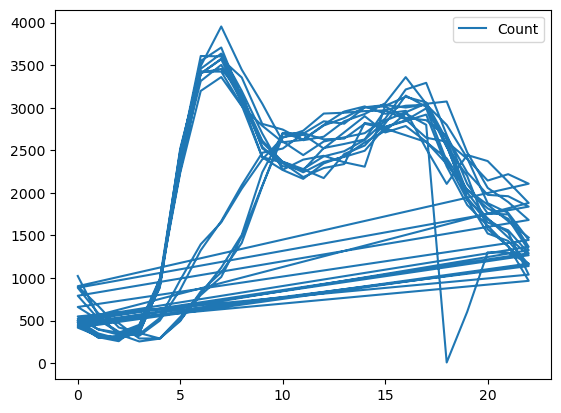

In [59]:
df_TS.query('Location_id == "SI80_3LCS" and Direction == "N"').plot()
plt.show()

### Date is not ideal, patch it up

In [61]:
from datetime import datetime
#https://www.tutorialspoint.com/python/time_strptime.htm
df_TS.Time = df_TS.Time.apply(
            lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M")
        )

In [62]:
df_TS_temp = df_TS.set_index('Time')

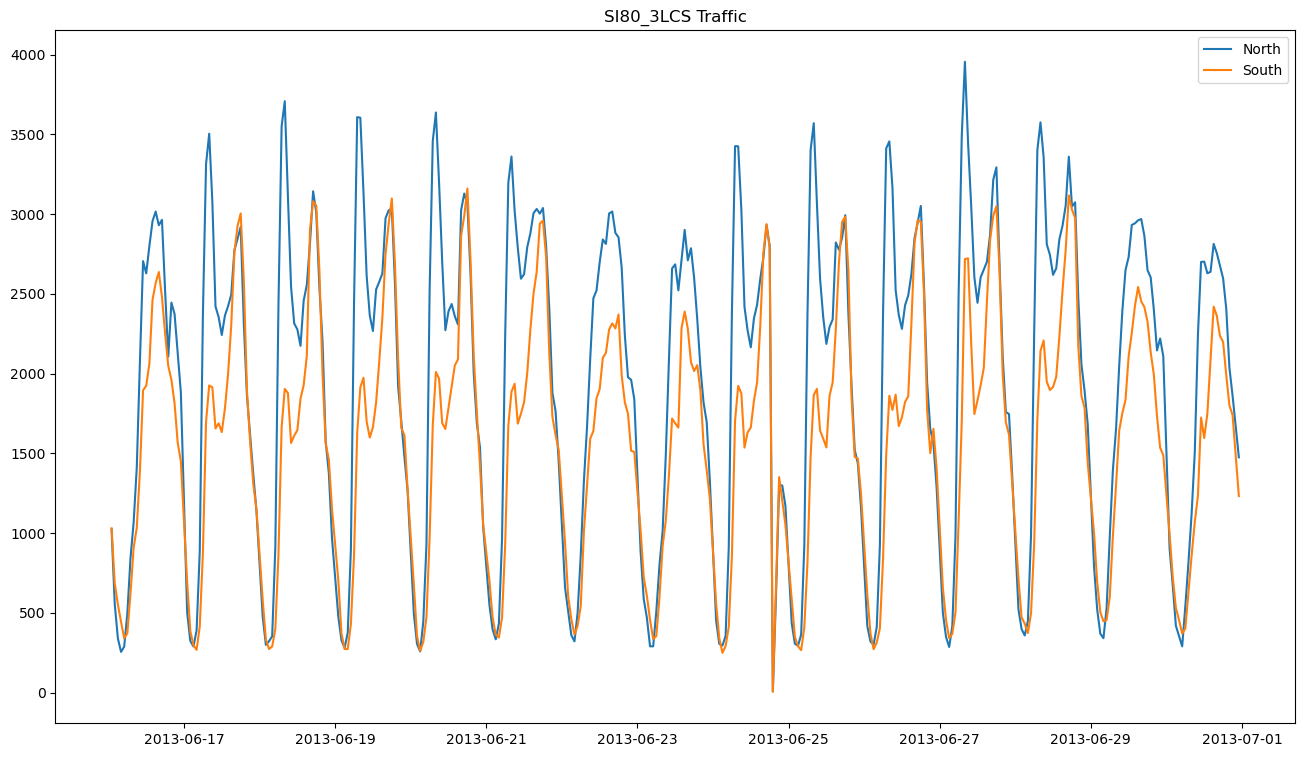

In [80]:
_t1 = df_TS_temp.query('Location_id == "SI80_3LCS" and Direction == "N"').Count
_t2 = df_TS_temp.query('Location_id == "SI80_3LCS" and Direction == "S"').Count
plt.figure(figsize =(16,9))
plt.plot(_t1)
plt.plot(_t2)
plt.legend(['North','South'])
plt.title('SI80_3LCS Traffic')
plt.show()

In [97]:
df_TS['Hour'] = list(df_TS.Time.apply(lambda x: x.hour))
df_TS['Day'] = list(df_TS.Time.apply(lambda x: x.date()))

In [100]:
df_TS.set_index('Time').to_csv('I-57-clean-final.csv')

In [101]:
df_TS.head()

,Direction,Time,Location_id,Count,Hour,Day
0,N,2013-06-16 01:00:00,SI80_3LCS,1024,1,2013-06-16
1,N,2013-06-16 02:00:00,SI80_3LCS,555,2,2013-06-16
2,N,2013-06-16 03:00:00,SI80_3LCS,340,3,2013-06-16
3,N,2013-06-16 04:00:00,SI80_3LCS,255,4,2013-06-16
4,N,2013-06-16 05:00:00,SI80_3LCS,288,5,2013-06-16


### Preping Test data

In [111]:
file_path_test = 'E:\\Data\\time_series_hw4\\I-57-2013-July-1.xls'

In [117]:
df_TS_test = Read_IDOT(file_path_test,'I-57-2013-July-01.xls',prefix='2013-07')
df_TS_test.Time = df_TS_test.Time.apply(
            lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M")
        )
df_TS_test['Hour'] = list(df_TS_test.Time.apply(lambda x: x.hour))
df_TS_test['Day'] = list(df_TS_test.Time.apply(lambda x: x.date()))

In [119]:
df_TS_test.set_index('Time').to_csv('I-57-clean-test.csv')